# Singular WF test

In [1]:
from Hubbard.core import *
import numpy as np
from tools.fix_phase import fix_phase
import numpy.linalg as la
import torch

N = 16
R0 = np.array([3, 3, 7.2])
dvr = MLWF(
    N=N,
    R0=R0,
    lattice=np.array([4], dtype=int),
    trap=(50, 1000),
    lc=(100, 1600),
    band=1,
    dim=1,
    avg=1,
    sparse=True,
    symmetry=True,
    verbosity=0)

E, W, parity = eigen_basis(dvr)
E = E[0]
W = W[0]
p = parity[0]
print(f'E = {E}')
print(f'parity = {p}')

R = Xmat(dvr, W, p)
R = [torch.from_numpy(Ri) for Ri in R]
dvr.verbosity = 3
solution = riemann_optimize(dvr, None, R)
U = site_order(dvr, solution, R)
A = U.conj().T @ (E[:, None] * U) * dvr.V0 / dvr.kHz_2p
print('detU =', la.det(U))
V = singleband_interaction(dvr, U, U, W, W, p,  p)
# for i in range(dvr.bands):
#     mu = np.diag(A[i])  # Diagonals are mu_i
#     t = -(A[i] - np.diag(mu))  # Off-diagonals are t_ij
#     print(f'V_{i+1}_i = ', np.real(mu))
#     print(f't_{i+1}_ij =', abs(t))
mu = np.diag(A)  # Diagonals are mu_i
t = -(A - np.diag(mu))  # Off-diagonals are t_ij
print('V_i = ', np.real(mu))
print('t_ij =', abs(t))
print('U_i =', abs(V))


E = [-3.56093826 -2.90358269 -2.29907563 -1.74287252]
parity = [[ 1  1  1]
 [-1  1  1]
 [ 1  1  1]
 [-1  1  1]]
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +3.0444690204461189e-01    1.57229316e-01    
   2         +1.5759468745004407e-01    2.75412341e-01    
   3         +1.2722216922747887e-01    2.94671645e-01    
   4         +9.1606138275781165e-02    2.33288427e-01    
   5         +5.9757902026241941e-02    1.21803932e-01    
   6         +4.1823478828709446e-02    9.49935790e-02    
   7         +1.7141143011447521e-02    7.52632692e-02    
   8         +8.0997761145576476e-03    4.90413087e-02    
   9         +1.8407682513382076e-03    3.71354265e-02    
  10         +3.8712196553930805e-04    1.82860272e-02    
  11         +5.2961980535900138e-05    4.02786145e-03    
  12         +3.2026744509535492e-05    3.17678532e-03    
  13         +1.4229731259797350e-05    3.720122

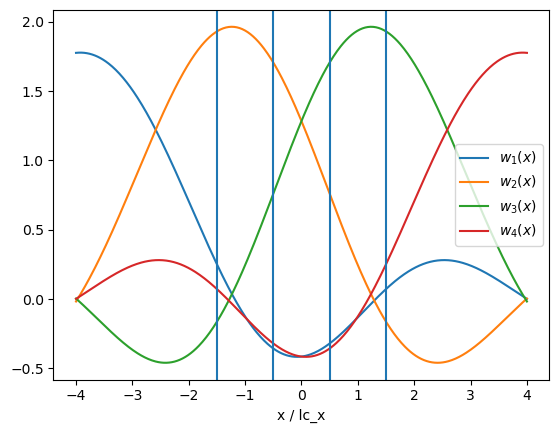

In [2]:
import matplotlib.pyplot as plt

x = np.linspace(-4 * dvr.lc[0], 4 * dvr.lc[0], 500)
y = np.array([0])
z = np.array([0])
plt.plot(x / dvr.lc[0],
         fix_phase(wannier_func(dvr, W, U, p,
                                [x, y, z])[:, 0, 0, :]),
         label=tuple(f'$w_{i + 1}(x)$' for i in range(dvr.Nsite)))
plt.xlabel('x / lc_x')
plt.legend()
plt.axvline(-1.5)
plt.axvline(-0.5)
plt.axvline(1.5)
plt.axvline(0.5)

### 2D square expectation value test

In [3]:
from Hubbard.core import *
import numpy as np
from tools.fix_phase import fix_phase
import numpy.linalg as la
import torch
import itertools as it

N = 16
R0 = np.array([3, 3, 7.2])
dvr = MLWF(
    N=N,
    R0=R0,
    lattice=np.array([3, 3], dtype=int),
    trap=(50, 1000),
    lc=(1000, 1000),
    band=1,
    dim=2,
    sparse=True,
    symmetry=True,
    verbosity=0)

E, W, parity = eigen_basis(dvr)
E = E[0]
W = W[0]
p = parity[0]
print(f'E = {E}')
print(f'parity = {p}')

R = Xmat(dvr, W, p)
R = [torch.from_numpy(Ri) for Ri in R]
solution = riemann_optimize(dvr, None, R)
U = site_order(dvr, solution, R)
A = U.conj().T @ (E[:, None] * U) * dvr.V0 / dvr.kHz_2p
print('detU =', la.det(U))
V = singleband_interaction(dvr, U, U, W, W, p,  p)
# for i in range(dvr.bands):
#     mu = np.diag(A[i])  # Diagonals are mu_i
#     t = -(A[i] - np.diag(mu))  # Off-diagonals are t_ij
#     print(f'V_{i+1}_i = ', np.real(mu))
#     print(f't_{i+1}_ij =', abs(t))
mu = np.diag(A)  # Diagonals are mu_i
t = -(A - np.diag(mu))  # Off-diagonals are t_ij
print('V_i = ', np.real(mu))
print('t_ij =', abs(t))
print('U_i =', abs(V))


E = [-1.4911675  -1.38547389 -1.38547389 -1.28113713 -1.26954329 -1.2679606
 -1.16536608 -1.16536608 -1.11520142]
parity = [[ 1  1  1]
 [-1  1  1]
 [ 1 -1  1]
 [-1 -1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1 -1  1]
 [-1  1  1]
 [ 1 -1  1]]
detU = 1.0000000000000004
V_i =  [-64.63312437 -65.03744664 -64.63311312 -62.51685155 -65.0374663
 -62.51685416 -63.33185778 -65.29591878 -63.3318611 ]
t_ij = [[0.         1.08654898 2.70415588 2.06466143 2.63227735 1.30992216
  0.64899811 0.90328643 0.3987958 ]
 [1.08654898 0.         2.63227589 0.92776945 4.54980687 3.98459458
  1.21318879 2.67849666 1.99831417]
 [2.70415588 2.63227589 0.         1.30992015 1.08652729 2.06465892
  0.39880267 0.90328746 0.64899503]
 [2.06466143 0.92776945 1.30992015 0.         3.98458551 0.95736393
  1.98246871 0.03677577 0.11684004]
 [2.63227735 4.54980687 1.08652729 3.98458551 0.         0.92775168
  1.99832027 2.67849567 1.21318656]
 [1.30992216 3.98459458 2.06465892 0.95736393 0.92775168 0.
  0.1168335  0.03677648 1.982

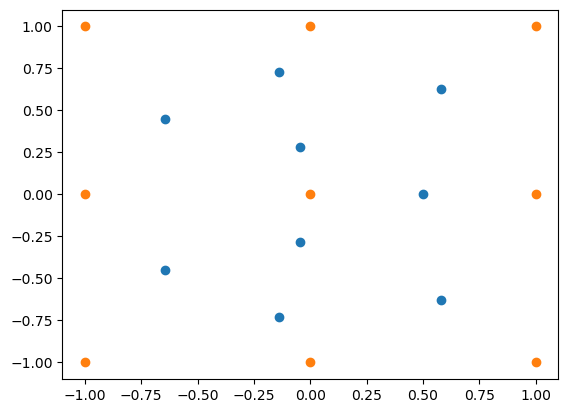

In [4]:
x = np.array([np.diag(U.T @ R[i].numpy() @ U) / dvr.lc[i]
                     for i in range(dvr.lattice_dim)]).T

plt.plot(x[:, 0], x[:, 1], 'o')
plt.plot(dvr.trap_centers[:, 0], dvr.trap_centers[:, 1], 'o')

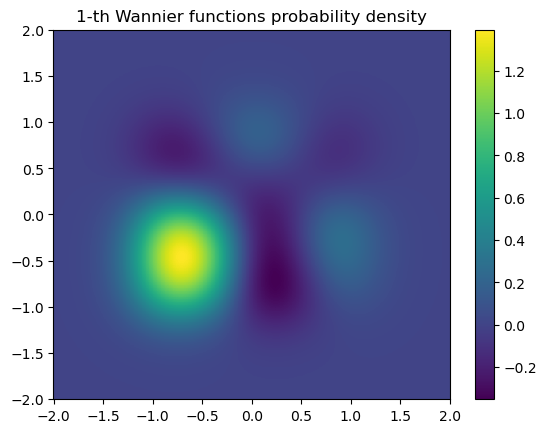

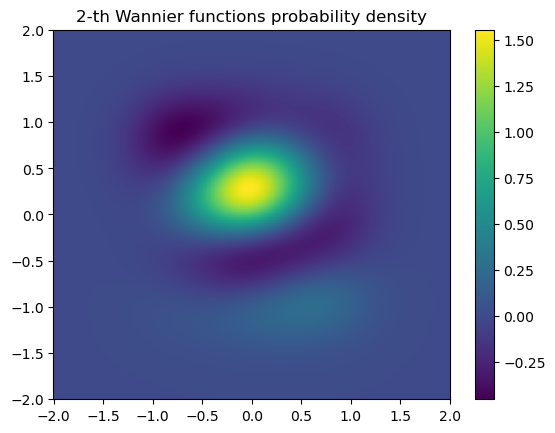

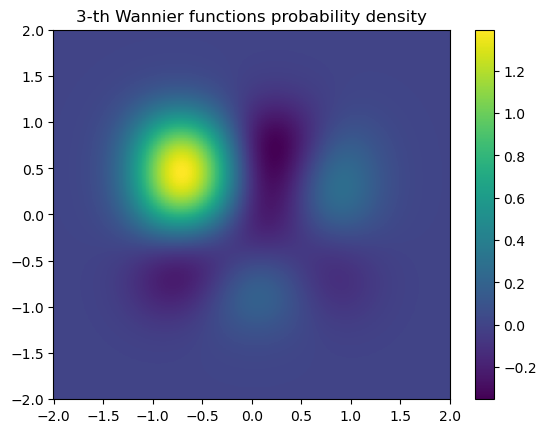

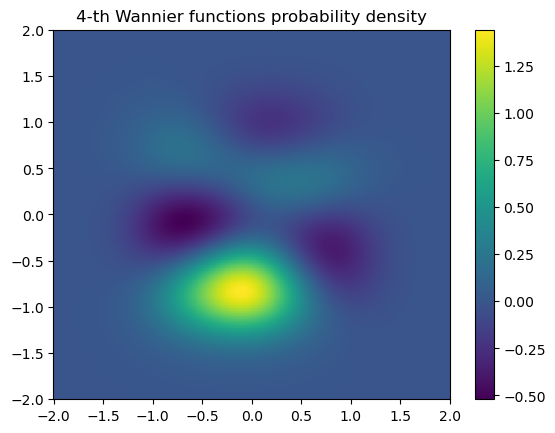

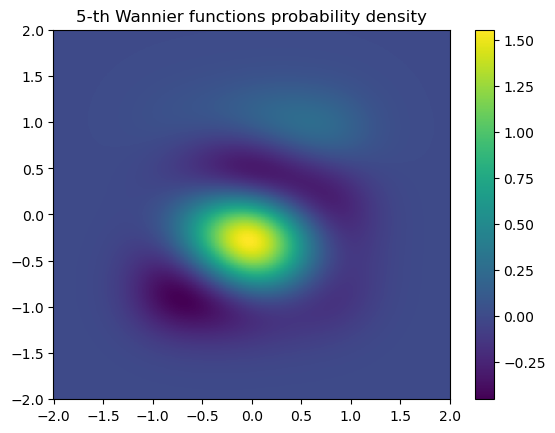

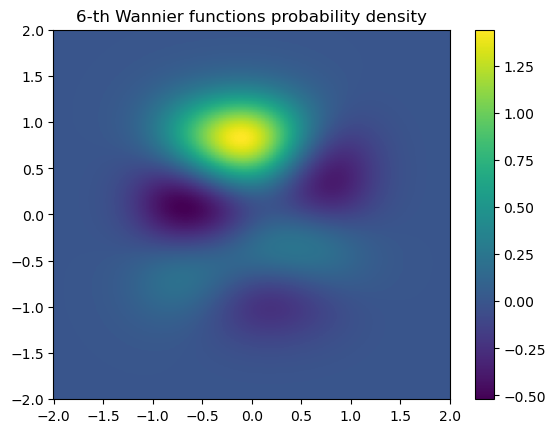

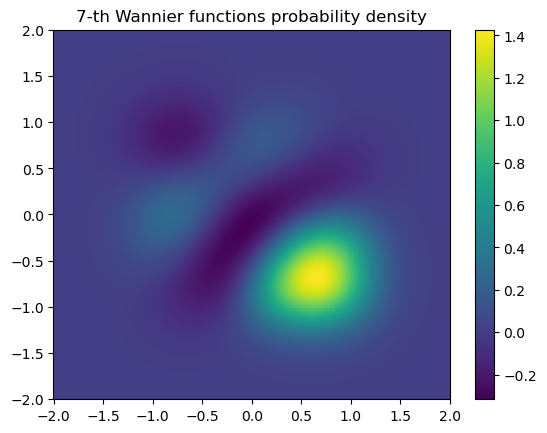

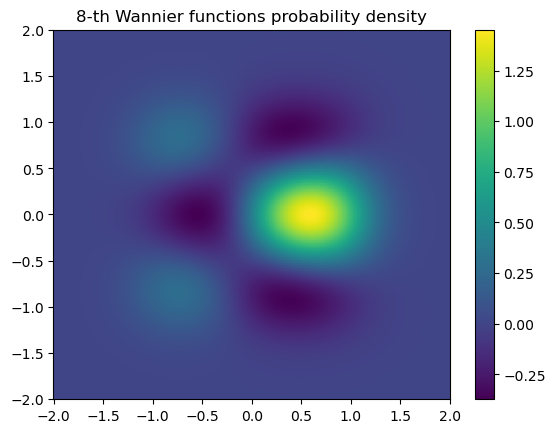

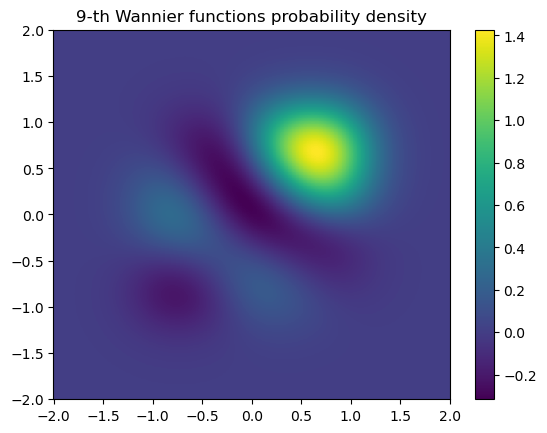

In [5]:
import matplotlib.colors as colors
from tools.fix_phase import fix_phase
import matplotlib.pyplot as plt
x = np.linspace(-dvr.R0[0] / 2, dvr.R0[0] / 2, 500)
y = np.linspace(-dvr.R0[1] / 2, dvr.R0[1] / 2, 500)
z = np.array([0])
wx = wannier_func(dvr, W, U, p, (x, y, z))
X = np.meshgrid(x, y, indexing='ij')

for i in range(dvr.Nsite):
    Wx = fix_phase(wx[..., 0, i], mode='svmd')
    plt.figure()
    plt.pcolormesh(*X, Wx)
    plt.colorbar()
    plt.title(f'{i+1}-th Wannier functions probability density')


The site-WF matching issue is not quite fixed, although th algorithm so far is relatively slow.